In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
words = open('/content/names.txt','r').read().splitlines()

In [ ]:
# Build the characters map
chars = sorted(list(set(''.join(words))))
stoi = {s : i + 1 for i , s in enumerate(chars)}
stoi['.'] = 0
itos = { i : s for s , i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build dataset
block_size = 3   # üçlü harf gruplarını alacağız

def build_dataset(words):

  X , Y = [] , []     # train ve target kısmı için iki boş liste oluştur

  for w in words :     # her kelimenin iterasyonuna başla
    context = [0] * block_size    # Seçilen kelime için 0 0 0 ile başlayan bir dizi oluştur
    for ch in w + '.':    # Seçilen kelime ve sonunda . için iterasyona başla
      ix = stoi[ch]       # harfleri sırasıyla her iterasyon için sayıya dönüştür
      X.append(context)   # Context kısmını yani 3 lü sayı dizilerini X e ekle Örneğin ilk olarak 0 0 0 eklensin
      Y.append(ix)         # Target kısmına o kelimenin seçilen harfinin sayı haline ekle Örneğin emma için e = 5 target  eklensin
      context = context[1:] + [ix]  # Target güncellensin 0 0 0 dan 0 0 5 sonra 0 5 13 sonra 5 13 13 sonra ...

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape , Y.shape)
  return X , Y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr , Ytr = build_dataset(words[:n1])  # %80 train  set
Xval , Yval = build_dataset(words[n1:n2])     # %10 Validation set
Xte , Yte = build_dataset(words[n2:])         # %10 test set

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP

n_embd = 10 # Her harf için 10 boyut yani 10 özelliği olduğunu düşünelim
n_hidden = 200  # Gizli katmanda 200 işçi çalışsın --- nöron

g = torch.Generator().manual_seed(42)


C = torch.randn((vocab_size , n_embd)  , generator=g)   #Her harfe 10 boyutunu belirlemek için random sayılar verdik 27 satır 10 sütun örneğin e = 5 sayısı için 10 tane rastgele verilmiş sayı temsil edecek
W1 = torch.randn((n_embd* block_size , n_hidden) , generator=g)   # 10*3 , 200 yani 30 satır 200 sütunluk bir random matris oluşturuldu Neden n_embd*block_size ? --> C[X] yapıldığında seçilen satır sayısı adedinde 3 tane harf ve bu 3 harfe ait 10 adet özellik bulunacak yani örneğin [32,3,10] şeklinde 3 harfteki özellikleri birleştirreceğiz 30 olacak
b1 = torch.randn(n_hidden , generator=g)
W2 = torch.randn((n_hidden,vocab_size) , generator=g)
b2 = torch.randn(vocab_size , generator=g)

#BatchNorm Parameters
bngain = torch.ones((1 , n_hidden))
bnbias = torch.zeros((1 , n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C , W1 , b1 , W2 , b2 , bngain , bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True


12297


BatchNorm Açıklaması olacak...

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0 , Xtr.shape[0] , (batch_size , ) , generator = g)
  Xb , Yb = Xtr[ix] , Ytr[ix]  # barch X , Y

  # forward Pass
  emb = C[Xb] #embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1)  #concatenate vectors
    # Linear Layer

  hpreact = embcat @ W1 + b1
    # batchnorm layer

  bnmeani = hpreact.mean(0 , keepdim = True)
  bnstdi = hpreact.std(0,keepdim = True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # ------------------------------------------------------
  # Non- linearity
  h = torch.tanh(hpreact)
  logits = hpreact @ W2 + b2
  loss = F.cross_entropy(logits , Yb)

  # backward Pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #Update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad


  # Parça istatistikleri
  if i % 10000 == 0:
    print(f'{i : 7d} / {max_steps : 7d} : {loss.item() : .4f}')
  lossi.append(loss.log10().item())



      0 /  200000 :  31.1360
  10000 /  200000 :  2.3515
  20000 /  200000 :  2.3349
  30000 /  200000 :  2.4241
  40000 /  200000 :  2.4142
  50000 /  200000 :  2.3471
  60000 /  200000 :  2.3638
  70000 /  200000 :  2.7129
  80000 /  200000 :  2.3414
  90000 /  200000 :  2.5462
 100000 /  200000 :  2.3685
 110000 /  200000 :  2.3658
 120000 /  200000 :  2.3641
 130000 /  200000 :  2.5956
 140000 /  200000 :  2.3559
 150000 /  200000 :  2.4562
 160000 /  200000 :  2.4219
 170000 /  200000 :  2.0701
 180000 /  200000 :  2.3215
 190000 /  200000 :  2.3295


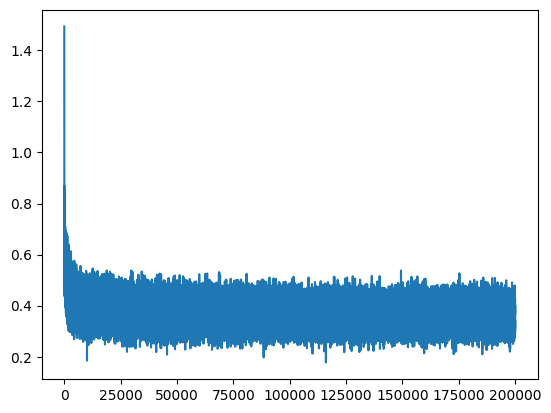

In [ ]:
import matplotlib.pyplot as plt
plt.plot(lossi)

In [ ]:
# Eğitim sonunda batch norm kalibresi
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0] , -1)
  hpreact = embcat @ W1 + b1
  bnmean = hpreact.mean(0 , keepdim = True)
  bnstd = hpreact.std(0 , keepdim = True)


In [ ]:
@torch.no_grad()   # türev izlemeyi devredışı bırak

def split_loss(split):

  x , y = {

      'train' : (Xtr,Ytr),
      'val' : (Xval , Yval),
      'test' : (Xte , Yte)
  }[split]

  emb = C[x]
  embcat = torch.view(emb.shape[0] , -1)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits , y)
  print(split , loss.item())


split_loss('train')
split_loss('val')